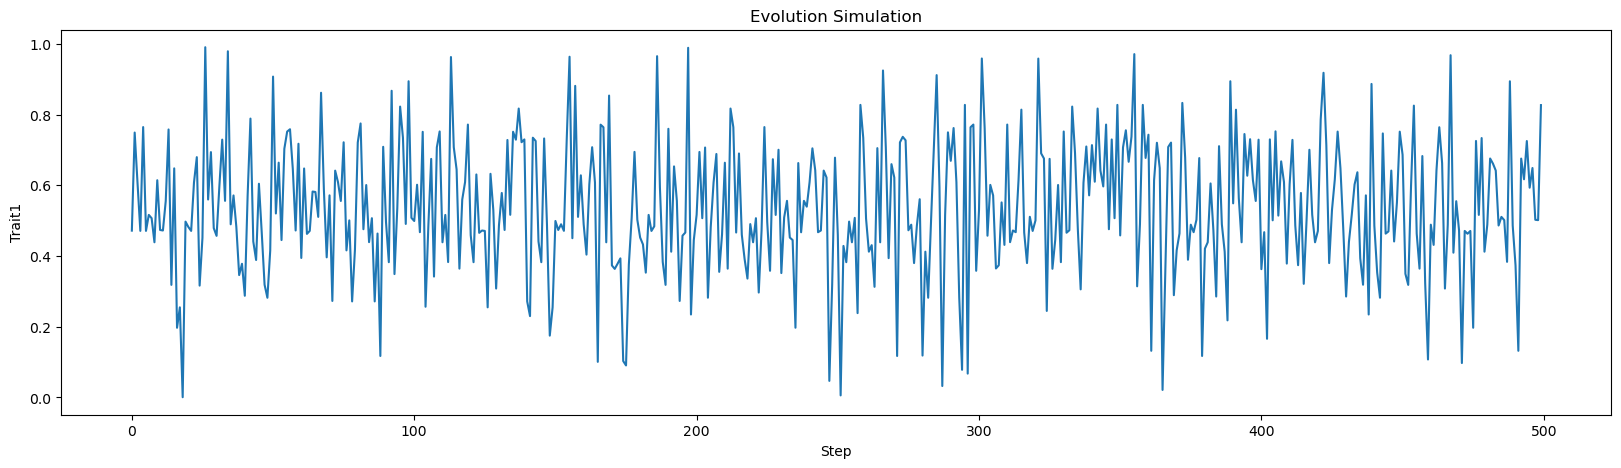

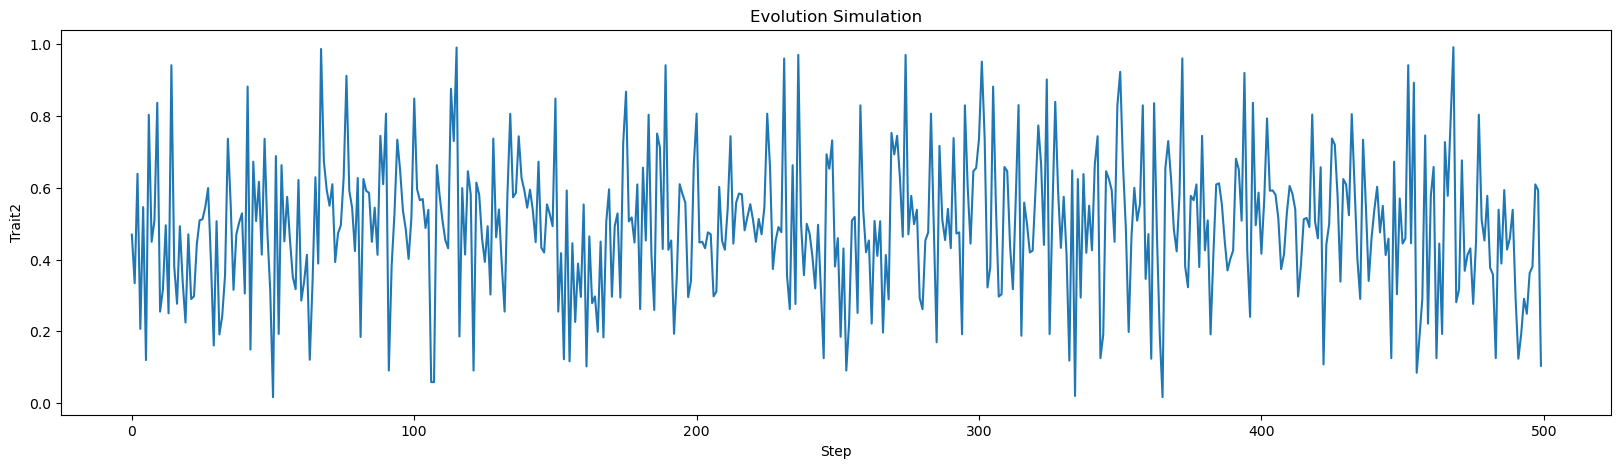

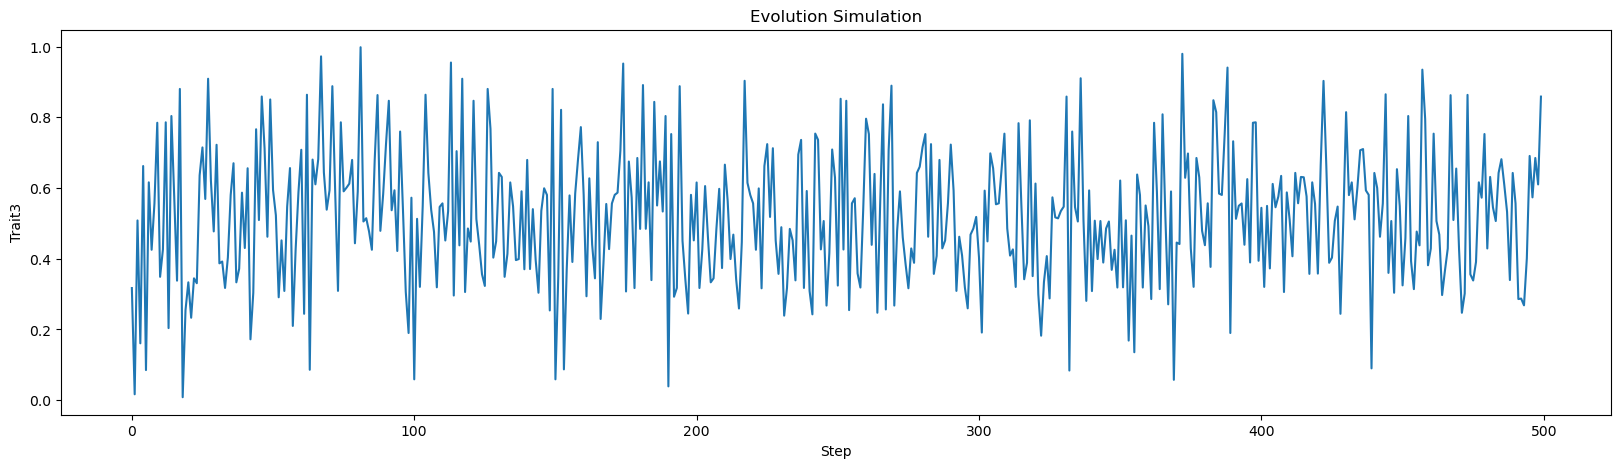

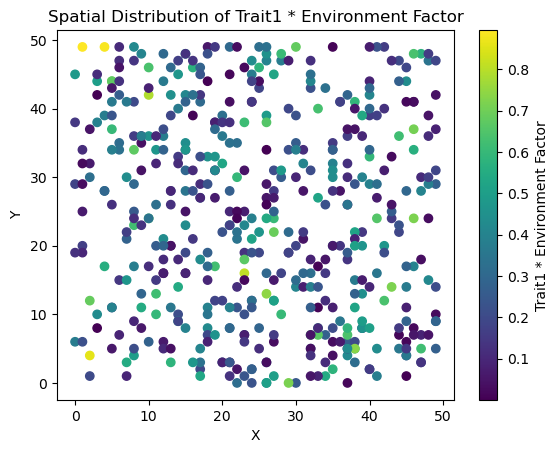

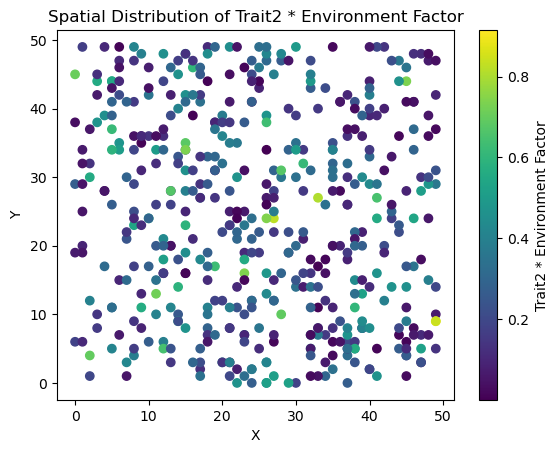

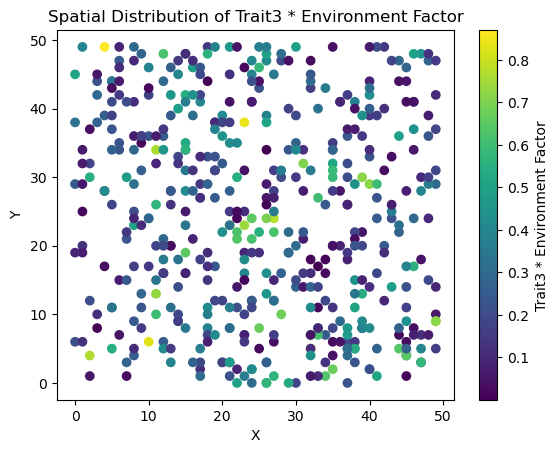

IndexError: single positional indexer is out-of-bounds

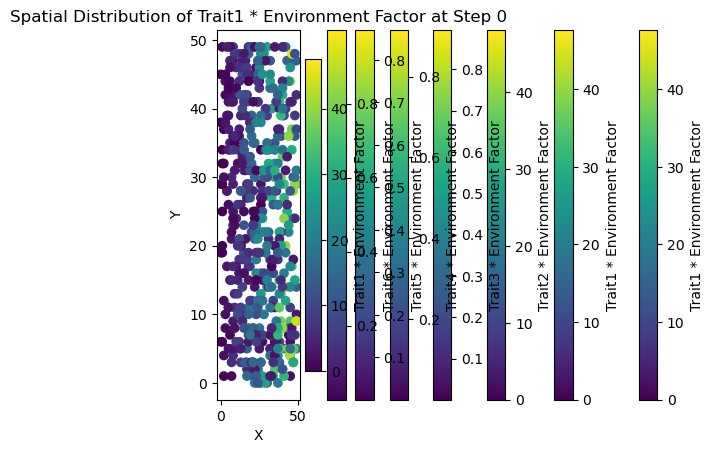

In [12]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class Creature(Agent):
    def __init__(self, unique_id, model, traits=None):
        super().__init__(unique_id, model)
        self.traits = traits if traits is not None else [model.random.random() for _ in range(3)]  # Use random() for a single random number
        self.environment_factor = model.random.uniform(0, 1)

    def step(self):
        # Example: Simple evolutionary process with environmental influence
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        neighbor_traits = [neighbor.traits for neighbor in neighbors]

        # Calculate average trait values of neighbors
        avg_neighbor_traits = np.mean(neighbor_traits, axis=0) if neighbors else self.traits

        # Calculate the difference between own traits and average neighbor traits
        trait_difference = np.array(avg_neighbor_traits) - np.array(self.traits)

        # Update traits based on a small fraction of the trait difference and environmental factor
        self.traits += 0.1 * trait_difference * self.environment_factor

class EvolutionModel(Model):
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents with random initial traits
        for i in range(self.num_agents):
            agent = Creature(i, self)
            x = np.random.choice(self.grid.width)
            y = np.random.choice(self.grid.height)
            self.grid.place_agent(agent, (x, y))
            self.schedule.add(agent)

        # DataCollector to track traits and environmental factors over time
        self.datacollector = DataCollector(agent_reporters={"x": lambda a: a.pos[0], 
                                                            "y": lambda a: a.pos[1], 
                                                            "Trait1": lambda a: a.traits[0], 
                                                            "Trait2": lambda a: a.traits[1], 
                                                            "Trait3": lambda a: a.traits[2], 
                                                            "Environment Factor": "environment_factor"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

# Run the model for a certain number of steps
N_steps = 500 # Increase this to get a longer time series
for i in range(N_steps):
    model.step()

# Extract and visualize data collected during the simulation
agent_data = model.datacollector.get_agent_vars_dataframe()

# Get data for the last step
last_step_data = agent_data.xs(N_steps-1, level="Step")

# Unstack the data for plotting
unstacked_data = last_step_data.unstack()

# Plot each trait separately
for trait in ["Trait1", "Trait2", "Trait3"]:
    plt.figure(figsize=(20, 5))
    unstacked_data[trait].plot()
    plt.xlabel('Step')
    plt.ylabel(trait)
    plt.title('Evolution Simulation')
    plt.show()

# Visualize the spatial distribution of traits and environmental factors in the last step
for trait in ["Trait1", "Trait2", "Trait3"]:
    fig, ax = plt.subplots()
    sc = ax.scatter(last_step_data["x"], last_step_data["y"],c=last_step_data[trait].values * last_step_data["Environment Factor"].values,cmap='viridis')
    plt.colorbar(sc, label=f'{trait} * Environment Factor')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Spatial Distribution of {trait} * Environment Factor')
    plt.show()

# %%

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Function to update the plot
# Function to update the plot
def update(i):
    ax.clear()
    sc = ax.scatter(agent_data.xs(i, level="Step")["x"], agent_data.xs(i, level="Step")["y"],
                    c=agent_data.xs(i, level="Step").iloc[:, i].values * agent_data.xs(i, level="Step")["Environment Factor"].values,
                    cmap='viridis')
    plt.colorbar(sc, label=f'Trait{i+1} * Environment Factor')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Spatial Distribution of Trait{i+1} * Environment Factor at Step {i}')


# Create an animation
ani = FuncAnimation(fig, update, frames=range(N_steps), repeat=True)

# Save the animation as a video file
ani.save('animation.mp4', writer='ffmpeg')
